In [1298]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

import re

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from xgboost import XGBClassifier

In [1299]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [1300]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1301]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1302]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Extract 'Title' Column
- This can hold insights as well as help us impute age

In [1303]:
df_train['Title'] = df_train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_test['Title'] = df_test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_train['Title'].value_counts(), df_test['Title'].value_counts()

(Title
 Mr          517
 Miss        182
 Mrs         125
 Master       40
 Dr            7
 Rev           6
 Col           2
 Mlle          2
 Major         2
 Ms            1
 Mme           1
 Don           1
 Lady          1
 Sir           1
 Capt          1
 Countess      1
 Jonkheer      1
 Name: count, dtype: int64,
 Title
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
 Name: count, dtype: int64)

In [1304]:
title_mapping = {
                    'Capt':       'Officer',
                    'Col':        'Officer',
                    'Major':      'Officer',
                    'Jonkheer':   'Royalty',
                    'Don':        'Royalty',
                    'Sir' :       'Royalty',
                    'Dr':         'Officer',
                    'Rev':        'Officer',
                    'Countess':   'Royalty',
                    'Dona':       'Royalty',
                    'Mme':        'Mrs',
                    'Mlle':       'Miss',
                    'Ms':         'Mrs',
                    'Mr' :        'Mr',
                    'Mrs' :       'Mrs',
                    'Miss' :      'Miss',
                    'Master' :    'Master',
                    'Lady' :      'Royalty'
                    } 

df_train['Title'] = df_train['Title'].map(title_mapping)
df_test['Title'] = df_test['Title'].map(title_mapping)

### Imputing Age
- Imputation of age on the entirely column seems lacking. We have additional information like title, gender and the Pclass, which should help us provide a better educated imputation for age.

In [1305]:
print(df_train.groupby(['Title', 'Sex', 'Pclass'])['Age'].median())
print(df_test.groupby(['Title', 'Sex', 'Pclass'])['Age'].median())

Title    Sex     Pclass
Master   male    1          4.0
                 2          1.0
                 3          4.0
Miss     female  1         30.0
                 2         24.0
                 3         18.0
Mr       male    1         40.0
                 2         31.0
                 3         26.0
Mrs      female  1         40.0
                 2         31.5
                 3         31.0
Officer  female  1         49.0
         male    1         51.0
                 2         46.5
Royalty  female  1         40.5
         male    1         40.0
Name: Age, dtype: float64
Title    Sex     Pclass
Master   male    1          9.5
                 2          5.0
                 3          7.0
Miss     female  1         32.0
                 2         19.5
                 3         22.0
Mr       male    1         42.0
                 2         28.0
                 3         25.0
Mrs      female  1         48.0
                 2         29.0
                 3         28.

In [1306]:
ages_train = df_train.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median')
df_train.Age = df_train.Age.fillna(ages_train)

ages_test = df_test.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform('median')
df_test.Age = df_test.Age.fillna(ages_test)

### Handling family
- Lets see if people traveling together/with family effects survival rate.

In [1307]:
df_train['FamilySize'] = df_train['Parch'] + df_train['SibSp']
df_test['FamilySize'] = df_test['Parch'] + df_test['SibSp']

df_train['IsAlone'] = df_train['FamilySize'] == 0
df_test['IsAlone'] = df_test['FamilySize'] == 0

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


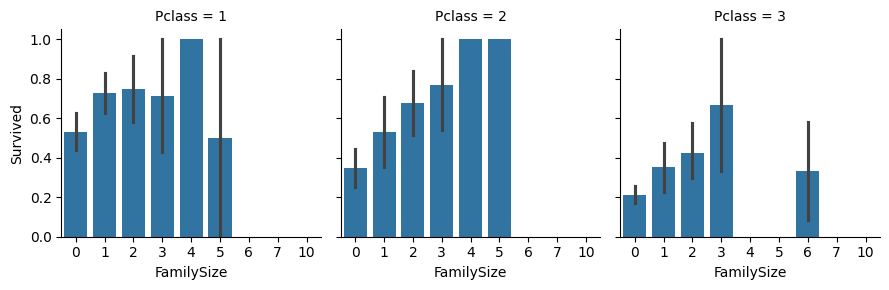

In [1308]:
g = sns.FacetGrid(df_train, col='Pclass')
g.map(sns.barplot, 'FamilySize', 'Survived')

In [1309]:
def FamilySize(x):
    if x == 1 or x == 2:
        return 'little'
    elif x == 3:
        return 'medium'
    elif x >= 5:
        return 'big'
    else:
        return 'none'
#Applying it
df_train['FamilySize'] = df_train['FamilySize'].apply(lambda x : FamilySize(x))
df_test['FamilySize'] = df_test['FamilySize'].apply(lambda x : FamilySize(x))

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


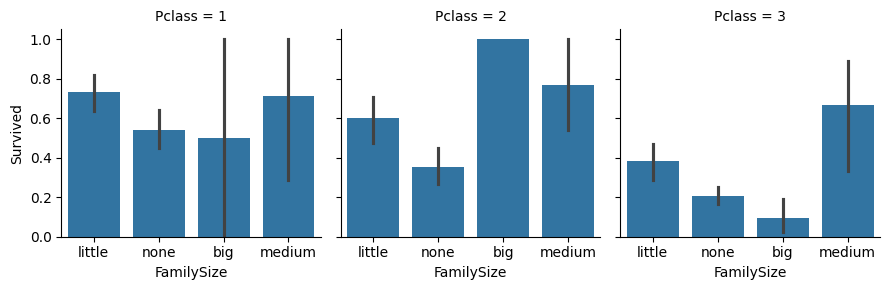

In [1310]:
g = sns.FacetGrid(df_train, col='Pclass')
g.map(sns.barplot, 'FamilySize', 'Survived')

### Checking ticket
- Lets see if we can extrapolate anything from ticket

In [1311]:
def Ticket_Prefix(x):
    l=x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'
df_train['TicketPrefix'] = df_train['Ticket'].apply(lambda x: Ticket_Prefix(x))
df_test['TicketPrefix'] = df_test['Ticket'].apply(lambda x: Ticket_Prefix(x))

In [1312]:
df_train.groupby(['TicketPrefix'])['Survived'].mean().sort_values(), df_train['TicketPrefix'].value_counts()

(TicketPrefix
 A./5.         0.000000
 A.5.          0.000000
 A/4           0.000000
 A/4.          0.000000
 A4.           0.000000
 A/S           0.000000
 C.A./SOTON    0.000000
 CA            0.000000
 Fa            0.000000
 F.C.          0.000000
 S.O.C.        0.000000
 S.P.          0.000000
 S.O.P.        0.000000
 S.C./A.4.     0.000000
 S.O./P.P.     0.000000
 SCO/W         0.000000
 W.E.P.        0.000000
 W/C           0.000000
 SOTON/O2      0.000000
 A/5           0.100000
 W./C.         0.111111
 CA.           0.125000
 SOTON/O.Q.    0.125000
 A/5.          0.142857
 SOTON/OQ      0.142857
 None          0.383459
 SC/PARIS      0.400000
 C             0.400000
 STON/O2.      0.444444
 C.A.          0.481481
 SC/Paris      0.500000
 P/PP          0.500000
 WE/P          0.500000
 S.C./PARIS    0.500000
 SC/AH         0.500000
 PC            0.650000
 PP            0.666667
 F.C.C.        0.800000
 S.W./PP       1.000000
 SC            1.000000
 SC/AHBasle    1.000000
 S

### Cabin
- Lets see what we can get from cabin

In [1313]:
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown')
df_test['Cabin'] = df_test['Cabin'].fillna('Unknown')

#Extract first letter
df_train['Cabin'] = df_train['Cabin'].map(lambda x : x[0])
df_test['Cabin'] = df_test['Cabin'].map(lambda x : x[0])

<Axes: xlabel='count', ylabel='Cabin'>

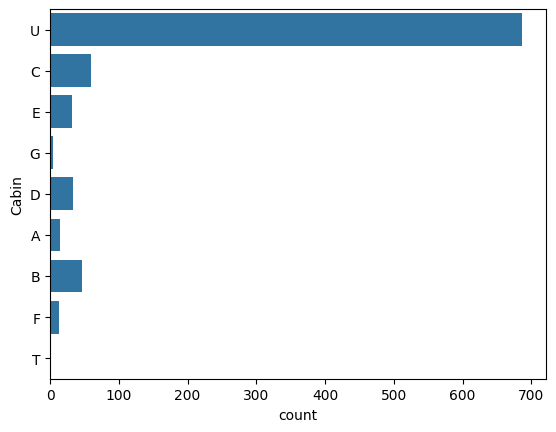

In [1314]:
sns.countplot(y='Cabin',data=df_train)

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


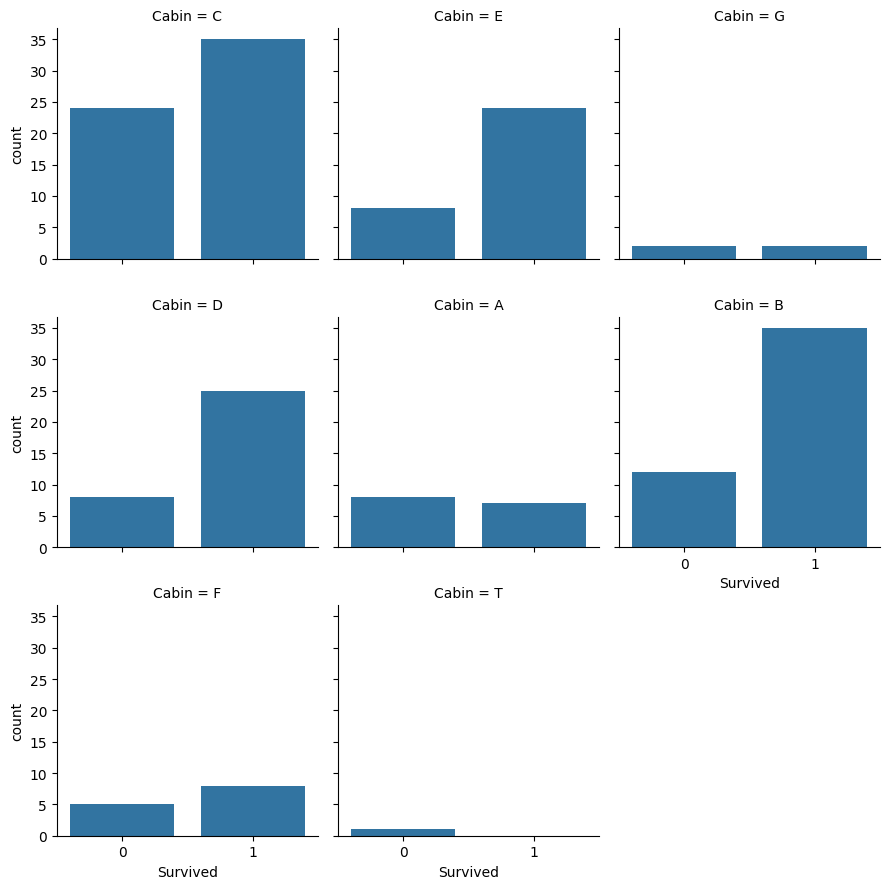

In [1315]:
g = sns.FacetGrid(df_train[df_train['Cabin'] != 'U'], col='Cabin', col_wrap=3)
g.map(sns.countplot, 'Survived')

### Handle Ticket Group Size

In [1316]:
grouped_train = df_train.groupby('Ticket')
for ticket, group in grouped_train:
    df_train.loc[group.index, 'TicketGroup'] = group.shape[0]

grouped_test = df_test.groupby('Ticket')
for ticket, group in grouped_test:
    df_test.loc[group.index, 'TicketGroup'] = group.shape[0]

print(df_train['TicketGroup'].value_counts())

TicketGroup
1.0    547
2.0    188
3.0     63
4.0     44
7.0     21
6.0     18
5.0     10
Name: count, dtype: int64


<Axes: xlabel='TicketGroup', ylabel='Survived'>

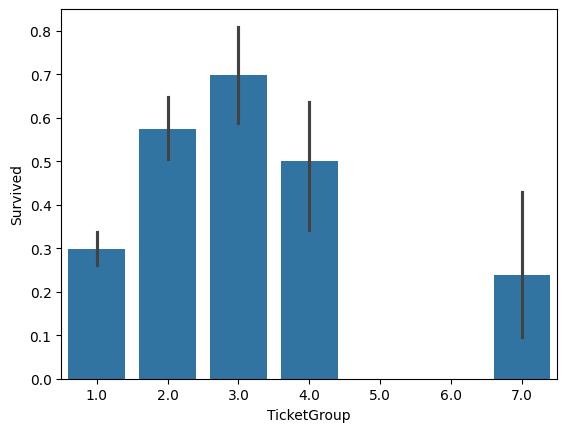

In [1317]:
sns.barplot(x='TicketGroup',y='Survived',data=df_train)

In [1318]:
df_train['BinnedTicketGroup'] = df_train['TicketGroup'].apply(lambda x: 'alone' if x == 1.0 else 'medium' if 2.0 <= x <= 4.0 else 'large')
df_test['BinnedTicketGroup'] = df_test['TicketGroup'].apply(lambda x: 'alone' if x == 1.0 else 'medium' if 2.0 <= x <= 4.0 else 'large')

<Axes: xlabel='BinnedTicketGroup', ylabel='Survived'>

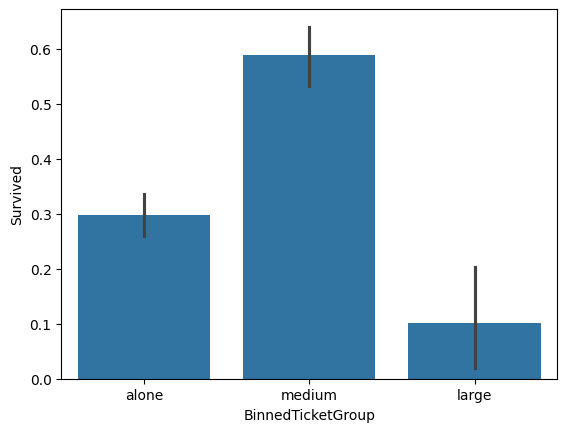

In [1319]:
sns.barplot(x='BinnedTicketGroup',y='Survived',data=df_train)

### Handle fare

In [1320]:
# impute missing fare for the test set
df_train['Fare'] = df_train['Fare'].fillna(df_train['Fare'].median())
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

In [1321]:
df_train['AdjustedFare'] = df_train['Fare']
grouped_train = df_train.groupby('Ticket')
for ticket, group in grouped_train:
    if group['Fare'].nunique() == 1:
        df_train.loc[group.index, 'AdjustedFare'] = group['Fare'].values[0] / group.shape[0]

df_test['AdjustedFare'] = df_test['Fare']
grouped_test = df_test.groupby('Ticket')
for ticket, group in grouped_test:
    if group['Fare'].nunique() == 1:
        df_test.loc[group.index, 'AdjustedFare'] = group['Fare'].values[0] / group.shape[0]

<Axes: xlabel='AdjustedFare', ylabel='Count'>

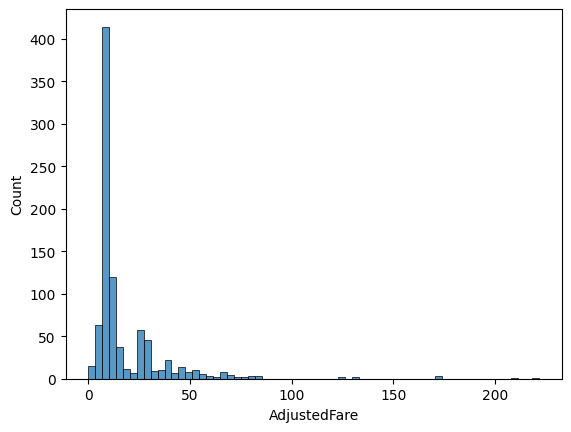

In [1322]:
sns.histplot(x='AdjustedFare',data=df_train)

In [1323]:
bins = 5
df_train['BinnedAdjustedFare'] = pd.qcut(df_train['AdjustedFare'], bins, labels=[str(i) for i in range(bins)])
df_test['BinnedAdjustedFare'] = pd.qcut(df_test['AdjustedFare'], bins, labels=[str(i) for i in range(bins)])
df_train['BinnedFare'] = pd.qcut(df_train['Fare'], bins, labels=[str(i) for i in range(bins)])
df_test['BinnedFare'] = pd.qcut(df_test['Fare'], bins, labels=[str(i) for i in range(bins)])
print(df_train['BinnedAdjustedFare'].value_counts())

BinnedAdjustedFare
1    216
3    189
0    180
4    166
2    140
Name: count, dtype: int64


<Axes: xlabel='BinnedAdjustedFare', ylabel='Survived'>

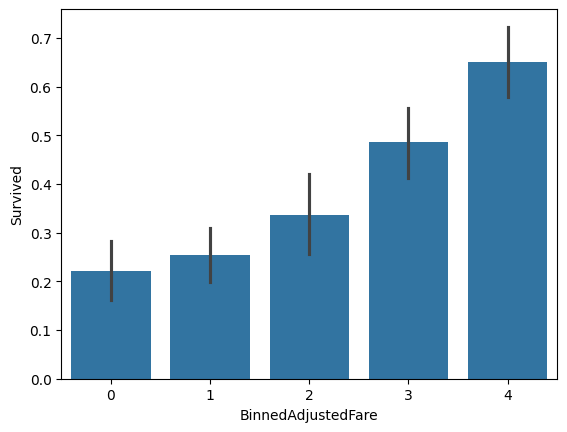

In [1324]:
sns.barplot(x='BinnedAdjustedFare',y='Survived',data=df_train)

## Handle Age

In [1325]:
df_train.loc[ df_train['Age'] <= 16, 'BinnedAge'] = 0
df_train.loc[(df_train['Age'] > 16) & (df_train['Age'] <= 26), 'BinnedAge'] = 1
df_train.loc[(df_train['Age'] > 26) & (df_train['Age'] <= 36), 'BinnedAge'] = 2
df_train.loc[(df_train['Age'] > 36) & (df_train['Age'] <= 62), 'BinnedAge'] = 3
df_train.loc[ df_train['Age'] > 62, 'BinnedAge'] = 4

df_test.loc[ df_test['Age'] <= 16, 'BinnedAge'] = 0
df_test.loc[(df_test['Age'] > 16) & (df_test['Age'] <= 26), 'BinnedAge'] = 1
df_test.loc[(df_test['Age'] > 26) & (df_test['Age'] <= 36), 'BinnedAge'] = 2
df_test.loc[(df_test['Age'] > 36) & (df_test['Age'] <= 62), 'BinnedAge'] = 3
df_test.loc[ df_test['Age'] > 62, 'BinnedAge'] = 4

<Axes: xlabel='BinnedAge', ylabel='Survived'>

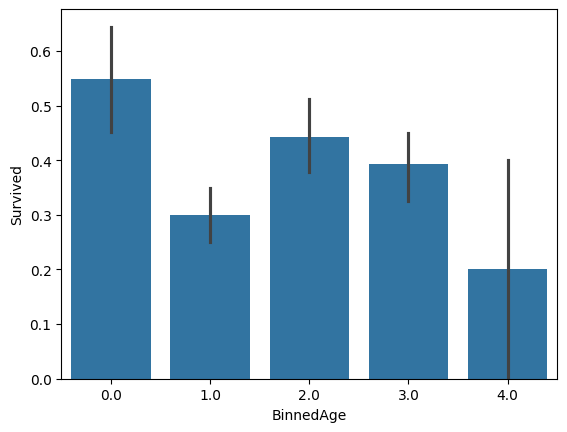

In [1326]:
sns.barplot(x='BinnedAge',y='Survived',data=df_train)

In [1327]:
df_train['Embarked'] = df_train['Embarked'].fillna(df_train['Embarked'].value_counts().idxmax())
df_test['Embarked'] = df_test['Embarked'].fillna(df_test['Embarked'].value_counts().idxmax())

In [1328]:
df_train.isna().sum(), df_test.isna().sum()

(PassengerId           0
 Survived              0
 Pclass                0
 Name                  0
 Sex                   0
 Age                   0
 SibSp                 0
 Parch                 0
 Ticket                0
 Fare                  0
 Cabin                 0
 Embarked              0
 Title                 0
 FamilySize            0
 IsAlone               0
 TicketPrefix          0
 TicketGroup           0
 BinnedTicketGroup     0
 AdjustedFare          0
 BinnedAdjustedFare    0
 BinnedFare            0
 BinnedAge             0
 dtype: int64,
 PassengerId           0
 Pclass                0
 Name                  0
 Sex                   0
 Age                   0
 SibSp                 0
 Parch                 0
 Ticket                0
 Fare                  0
 Cabin                 0
 Embarked              0
 Title                 0
 FamilySize            0
 IsAlone               0
 TicketPrefix          0
 TicketGroup           0
 BinnedTicketGroup     0
 AdjustedF

In [1363]:
one_hot_columns = ['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'TicketPrefix', 
                   'BinnedTicketGroup', 'BinnedAge']
# train
dummies = pd.get_dummies(df_train[one_hot_columns],columns=one_hot_columns)
df_train_temp = df_train.join(dummies)

# test
dummies = pd.get_dummies(df_test[one_hot_columns],columns=one_hot_columns)
df_test_temp = df_test.join(dummies)

In [1364]:
always_drop = ['Name', 'SibSp', 'Parch', 'Ticket', 'Age', 'TicketGroup']

modifier = ['Fare', 'BinnedFare', 'BinnedAdjustedFare'] 

to_drop = always_drop + modifier + one_hot_columns

new_df_train = df_train_temp.drop(columns=to_drop)
new_df_test = df_test_temp.drop(columns=to_drop)

new_df_train.columns

Index(['PassengerId', 'Survived', 'AdjustedFare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'FamilySize_big', 'FamilySize_little', 'FamilySize_medium',
       'FamilySize_none', 'IsAlone_False', 'IsAlone_True',
       'TicketPrefix_A./5.', 'TicketPrefix_A.5.', 'TicketPrefix_A/4',
       'TicketPrefix_A/4.', 'TicketPrefix_A/5', 'TicketPrefix_A/5.',
       'TicketPrefix_A/S', 'TicketPrefix_A4.', 'TicketPrefix_C',
       'TicketPrefix_C.A.', 'TicketPrefix_C.A./SOTON', 'TicketPrefix_CA',
       'TicketPrefix_CA.', 'TicketPrefix_F.C.', 'TicketPrefix_F.C.C.',
       'TicketPrefix_Fa', 'TicketPrefix_None', 'TicketPrefix_P/PP',
       'TicketPrefix_PC', 'TicketPrefix_PP', 'TicketPrefix_S.C./A.4.',
       'TicketPr

In [1365]:
X_train = new_df_train.drop('Survived',axis=1)
Y_train = new_df_train['Survived']
X_test = new_df_test.drop('PassengerId',axis=1).copy()

In [1366]:
best_params =  {
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': 5
}


In [1367]:
clf = XGBClassifier(**best_params)
clf = clf.fit(X_train, Y_train)
indices = np.argsort(clf.feature_importances_)[::-1]

In [1368]:
# Print the feature ranking
model = SelectFromModel(clf,prefit=True)
train_new = model.transform(X_train)
display(train_new.shape)
print('Feature ranking:')
for f in range(X_train.shape[1]):
    print(f,X_train.columns[indices[f]],clf.feature_importances_[indices[f]])

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(891, 16)

Feature ranking:
0 Title_Mr 0.40842706
1 BinnedTicketGroup_large 0.09426612
2 Title_Officer 0.06461582
3 Pclass_3 0.059650023
4 Cabin_U 0.030245552
5 FamilySize_none 0.023382276
6 Embarked_S 0.018418156
7 TicketPrefix_W./C. 0.017112015
8 BinnedAge_3.0 0.015963018
9 Title_Royalty 0.01552566
10 BinnedAge_2.0 0.014507863
11 FamilySize_medium 0.014037233
12 TicketPrefix_STON/O2. 0.013925144
13 Pclass_1 0.013582863
14 AdjustedFare 0.012269171
15 Embarked_C 0.012215059
16 BinnedAge_0.0 0.011768155
17 Cabin_C 0.011320292
18 Pclass_2 0.0109085655
19 BinnedAge_1.0 0.010080848
20 TicketPrefix_None 0.010063176
21 BinnedTicketGroup_medium 0.009751159
22 PassengerId 0.009423921
23 FamilySize_little 0.008969932
24 IsAlone_False 0.008769894
25 Cabin_D 0.008003646
26 Title_Miss 0.007895193
27 BinnedTicketGroup_alone 0.007849898
28 Embarked_Q 0.007595188
29 Cabin_E 0.0066516297
30 Cabin_B 0.0065325946
31 TicketPrefix_PC 0.0063866084
32 Sex_female 0.0059601385
33 Title_Master 0.0059274286
34 BinnedAge_4

In [1369]:
best_features = X_train.columns[indices[0:train_new.shape[1]]]
X_train  = new_df_train[best_features]
X_test = new_df_test[best_features]
X_train.columns

Index(['Title_Mr', 'BinnedTicketGroup_large', 'Title_Officer', 'Pclass_3',
       'Cabin_U', 'FamilySize_none', 'Embarked_S', 'TicketPrefix_W./C.',
       'BinnedAge_3.0', 'Title_Royalty', 'BinnedAge_2.0', 'FamilySize_medium',
       'TicketPrefix_STON/O2.', 'Pclass_1', 'AdjustedFare', 'Embarked_C'],
      dtype='object')

In [1376]:
# XGBoost
parameter_grid = {
    'n_estimators': [200,300,400],
    'learning_rate': [0.2, 0.1, 0.01, 0.001],
    'max_depth': [4],
    'colsample_bytree': [0.0,0.1,0.2,0.3,0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}


grid_search = GridSearchCV(XGBClassifier(), n_jobs=-1, param_grid=parameter_grid, cv=StratifiedKFold(n_splits=5,shuffle=True),verbose=1)
grid_search.fit(X_train, Y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.8428598330299415
Best parameters: {'colsample_bytree': 0.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}


In [1377]:
best_index = grid_search.best_index_
fold_scores = [
    grid_search.cv_results_['split0_test_score'][best_index],
    grid_search.cv_results_['split1_test_score'][best_index],
    grid_search.cv_results_['split2_test_score'][best_index],
    grid_search.cv_results_['split3_test_score'][best_index],
    grid_search.cv_results_['split4_test_score'][best_index]
]

print('mean',np.mean(fold_scores))
print('min:',min(fold_scores),'max:',max(fold_scores))
print('min-max diff:',abs(min(fold_scores)-max(fold_scores)))

mean 0.8428598330299415
min: 0.8202247191011236 max: 0.8547486033519553
min-max diff: 0.03452388425083175


In [1378]:
model = grid_search.best_estimator_

In [1379]:
submission_df = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': model.predict(X_test)})

In [1380]:
submission_df.to_csv('./data/my_submission.csv',index=False)